In [27]:
import json
import funzioni_topic_detection as ftd
import funzioni_preprocessing_text as fpt
import gensim
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy import sparse
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

In [4]:
corpus=json.load(open('dataset/allDocuments.json'))

In [5]:
postPuliti,bigram_mdl=fpt.clear_corpus(corpus)

In [6]:
id2word = gensim.corpora.Dictionary(postPuliti)

corpus2 = [id2word.doc2bow(doc) for doc in postPuliti]
tfidf = TfidfModel(corpus2, id2word=id2word)
tfidfCorpus=[tfidf[bow] for bow in corpus2]

low_value = 0.01
low_value_words = []
for bow in corpus2:
    low_value_words += [id for id, value in tfidf[bow] if value < low_value]
id2word.filter_tokens(low_value_words)
new_corpus2=[]
newPostPuliti=[]
for doc in postPuliti:
    if bow:=id2word.doc2bow(doc):
        new_corpus2.append(bow)
        newPostPuliti.append(doc)

In [7]:
n_iter=300
cutoff_tf_idf=0.01
lemmatized_bigram_string=[' '.join(word) for word in postPuliti]
vectorizer = TfidfVectorizer()
M=vectorizer.fit_transform(lemmatized_bigram_string)
M=M.toarray()
row,column=M.shape
for i, j in itertools.product(range(row), range(column)):
    if M[i][j]<cutoff_tf_idf:
        M[i][j]=0
M=sparse.csr_matrix(M)

termini=vectorizer.get_feature_names_out().tolist()

In [2]:
import math
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[:n_top_words]
    coherence = 0
    for j_index in range(len(topic_top)):
        for i_index in range(j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [11]:
lsaCoerenza={}

In [30]:
for n_topics in range(5, 16):
    lsa = TruncatedSVD(n_components=n_topics, n_iter=300, random_state=42)
    lsa.fit(M)
    avg_coherence = get_average_topic_coherence(M, lsa.components_, 10)
    lsaCoerenza[n_topics]=abs(avg_coherence)

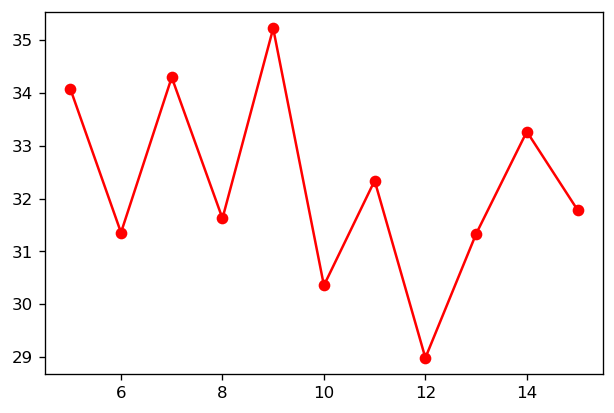

In [31]:
plt.plot(lsaCoerenza.keys(),lsaCoerenza.values(),marker='o',color='red')
plt.show()

In [43]:
lsa = TruncatedSVD(n_components=9, n_iter=300, random_state=42)
lsa.fit(M)

TruncatedSVD(n_components=9, n_iter=300, random_state=33)

In [44]:
get_average_topic_coherence(M, lsa.components_, 10)

-32.588856374164315

In [41]:
for i in [(f"concetto_{str(i)}", list(sorted(zip(termini, abs(j)), key=lambda x: x[1],reverse=True)[:10]))\
    for i, j in enumerate(lsa.components_)]:
    print(i)

('concetto_0', [('abortion', 0.2006920420366065), ('woman', 0.1604103037336443), ('people', 0.14209279096839356), ('state', 0.13982631825179778), ('year', 0.13866849797289285), ('city', 0.1229442813408486), ('decision', 0.1084569768271079), ('texas', 0.1025033515639509), ('week', 0.09686218514012232), ('change', 0.08667193026953877)])
('concetto_1', [('abortion', 0.3843048484459958), ('woman', 0.31594572526763515), ('state', 0.19422983393939366), ('decision', 0.15378283339293664), ('supreme_court', 0.11971678386187366), ('baby', 0.11772566306698849), ('covid', 0.11086182815112271), ('city', 0.10649721062934417), ('clinic', 0.09154424246275011), ('people', 0.09152607050634626)])
('concetto_2', [('covid', 0.4389971229778675), ('vaccinate', 0.20888336733639562), ('good', 0.1787917540285268), ('high_risk', 0.17195004090524524), ('virus_cause', 0.12980648620511026), ('illness', 0.11145196570793699), ('prematurely', 0.11145196570793699), ('sick', 0.11145196570793699), ('protect', 0.109925841

In [ ]:
coerenzaLSI=[]
for i in range(5,16):
    lsimodel=gensim.models.lsimodel.LsiModel(new_corpus2, num_topics=i, id2word=id2word,random_seed=42)
    cm=CoherenceModel(model=lsimodel, texts=newPostPuliti, coherence='c_v')
    coerenzaLSI.append((i,cm.get_coherence()))
    print(i,cm.get_coherence())

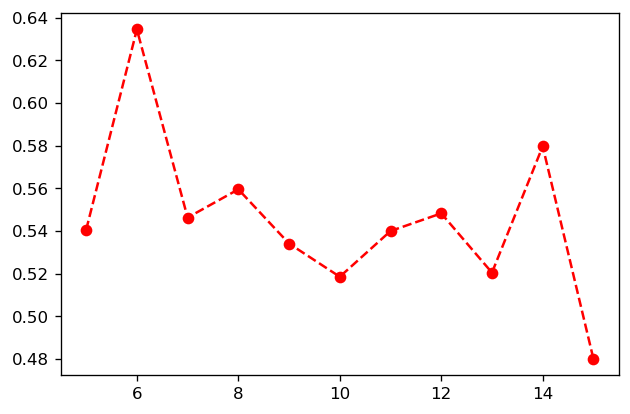

In [72]:
plt.plot([x[0] for x in coerenzaLSI],[x[1] for x in coerenzaLSI],marker='o',color='r',linestyle='--')
plt.show()

In [73]:
lsimodel=gensim.models.lsimodel.LsiModel(new_corpus2, num_topics=14, id2word=id2word,random_seed=42)

In [74]:
lsimodel.print_topics()

[(0,
  '0.309*"abortion" + 0.261*"woman" + 0.201*"year" + 0.179*"state" + 0.155*"people" + 0.141*"city" + 0.134*"baby" + 0.113*"change" + 0.097*"texas" + 0.092*"new"'),
 (1,
  '0.365*"abortion" + 0.335*"woman" + -0.185*"city" + 0.164*"baby" + -0.163*"heat_wave" + 0.142*"state" + -0.117*"people" + -0.113*"climate_change" + -0.106*"researcher" + -0.088*"ukraine"'),
 (2,
  '0.250*"heat_wave" + -0.240*"vote" + -0.176*"party" + 0.167*"researcher" + -0.166*"hochul" + 0.160*"climate_change" + -0.151*"win" + -0.129*"primary" + -0.124*"general_election" + 0.098*"extreme"'),
 (3,
  '-0.186*"vote" + -0.177*"heat_wave" + 0.170*"attack" + -0.152*"party" + -0.151*"year" + -0.148*"hochul" + -0.136*"win" + 0.125*"ukraine" + -0.121*"climate_change" + -0.119*"researcher"'),
 (4,
  '-0.196*"miah" + -0.179*"school" + 0.176*"city" + 0.175*"war" + -0.163*"attack" + -0.151*"student" + 0.150*"ukraine" + -0.135*"classroom" + -0.131*"shooting" + 0.126*"ukrainian"'),
 (5,
  '0.276*"high" + 0.270*"storm" + 0.259*

In [46]:
lsimodel=gensim.models.lsimodel.LsiModel(new_corpus2, num_topics=9, id2word=id2word,random_seed=42)

0.5341676070889525

In [48]:
lsimodel.print_topics()

[(0,
  '-0.309*"abortion" + -0.261*"woman" + -0.201*"year" + -0.179*"state" + -0.155*"people" + -0.141*"city" + -0.134*"baby" + -0.113*"change" + -0.097*"texas" + -0.092*"new"'),
 (1,
  '0.365*"abortion" + 0.335*"woman" + -0.185*"city" + 0.164*"baby" + -0.163*"heat_wave" + 0.142*"state" + -0.117*"people" + -0.113*"climate_change" + -0.106*"researcher" + -0.088*"ukraine"'),
 (2,
  '0.250*"heat_wave" + -0.240*"vote" + -0.176*"party" + 0.167*"researcher" + -0.166*"hochul" + 0.160*"climate_change" + -0.151*"win" + -0.129*"primary" + -0.124*"general_election" + 0.098*"extreme"'),
 (3,
  '-0.186*"vote" + -0.177*"heat_wave" + 0.170*"attack" + -0.152*"party" + -0.151*"year" + -0.148*"hochul" + -0.136*"win" + 0.125*"ukraine" + -0.121*"climate_change" + -0.119*"researcher"'),
 (4,
  '-0.196*"miah" + -0.179*"school" + 0.176*"city" + 0.175*"war" + -0.163*"attack" + -0.151*"student" + 0.150*"ukraine" + -0.135*"classroom" + -0.131*"shooting" + 0.126*"ukrainian"'),
 (5,
  '-0.276*"high" + -0.270*"sto

In [57]:
ldaModelDict={}

In [ ]:
coerenza=[]
for i in range(5,16):
    ldamodel=gensim.models.ldamodel.LdaModel(new_corpus2, num_topics=i, id2word=id2word,random_state=42)
    ldaModelDict[i]=ldamodel
    cm=CoherenceModel(model=ldamodel, texts=newPostPuliti, coherence='c_v')
    coerenza.append((i,cm.get_coherence()))
    print(i,cm.get_coherence())

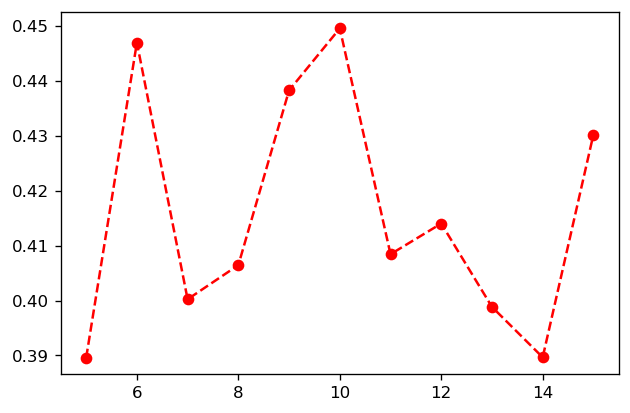

In [75]:
plt.plot([x[0] for x in coerenza],[x[1] for x in coerenza],marker='o',color='r',linestyle='--')
plt.show()

In [112]:
ldamodel=gensim.models.ldamodel.LdaModel(new_corpus2, num_topics=10, id2word=id2word,alpha=10,random_state=42)

In [113]:
for i in ldamodel.print_topics():
    print(i)

(0, '0.005*"year" + 0.003*"city" + 0.003*"people" + 0.003*"state" + 0.002*"abortion" + 0.002*"week" + 0.002*"woman" + 0.002*"use" + 0.002*"life" + 0.002*"decision"')
(1, '0.004*"people" + 0.003*"state" + 0.003*"year" + 0.003*"city" + 0.003*"abortion" + 0.003*"new" + 0.002*"time" + 0.002*"change" + 0.002*"help" + 0.002*"use"')
(2, '0.004*"people" + 0.004*"year" + 0.004*"city" + 0.003*"state" + 0.003*"abortion" + 0.003*"use" + 0.002*"change" + 0.002*"woman" + 0.002*"time" + 0.002*"new"')
(3, '0.004*"people" + 0.004*"year" + 0.003*"state" + 0.003*"abortion" + 0.003*"use" + 0.003*"city" + 0.002*"woman" + 0.002*"high" + 0.002*"week" + 0.002*"new"')
(4, '0.004*"year" + 0.004*"city" + 0.003*"abortion" + 0.003*"new" + 0.003*"people" + 0.002*"woman" + 0.002*"president" + 0.002*"use" + 0.002*"state" + 0.002*"life"')
(5, '0.004*"year" + 0.004*"people" + 0.003*"abortion" + 0.003*"state" + 0.002*"time" + 0.002*"week" + 0.002*"city" + 0.002*"protect" + 0.002*"new" + 0.002*"change"')
(6, '0.004*"peop

In [ ]:
hdpModelDict={}

In [ ]:
coerenzaHDP=[]
for i in range(5,16):
    hdpmodel=gensim.models.hdpmodelmodel.HdpModel(new_corpus2,id2word=id2word,random_state=42)
    hdpModelDict[i]=hdpmodel
    cm=CoherenceModel(model=hdpmodel, texts=newPostPuliti, coherence='c_v')
    coerenzaHDP.append((i,cm.get_coherence()))
    print(i,cm.get_coherence())

In [125]:
hdpmodel=gensim.models.hdpmodel.HdpModel(new_corpus2, id2word=id2word)
cm=CoherenceModel(model=hdpmodel, texts=newPostPuliti, coherence='c_v')
cm.get_coherence()

0.7888567685163492

In [126]:
hdpmodel.print_topics()

[(0,
  '0.004*stat + 0.003*hollywood + 0.002*base + 0.002*stricken + 0.002*exception + 0.002*son + 0.002*begin + 0.002*sotomayor + 0.002*not_direct + 0.002*prime_minister'),
 (1,
  '0.004*man + 0.003*speak + 0.003*lawton + 0.003*round + 0.002*manchester + 0.002*current + 0.002*note + 0.002*story + 0.002*quietly + 0.002*dixie_fire'),
 (2,
  '0.003*dark + 0.003*warm + 0.003*distress + 0.003*yell + 0.002*breaststroke + 0.002*forthcoming + 0.002*discovery + 0.002*melt + 0.002*americans + 0.002*rainfall'),
 (3,
  '0.003*thompson + 0.002*scarcity + 0.002*peculiar + 0.002*respite + 0.002*strain + 0.002*hyon + 0.002*constitution + 0.002*northeast + 0.002*fly + 0.002*loaf'),
 (4,
  '0.003*maze + 0.002*christian + 0.002*barricade + 0.002*provide + 0.002*tight + 0.002*not_wear + 0.002*columbia + 0.002*fairly + 0.002*mykolaiv + 0.002*wreck'),
 (5,
  '0.003*apply + 0.003*chile + 0.002*accelerate + 0.002*bar + 0.002*politico + 0.002*classmate + 0.002*consider + 0.002*pose + 0.002*ground + 0.002*pung